## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

In [15]:
import pandas as pd
import numpy as np

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

In [16]:
#data=pd.read_csv('/home/spiro/home/manentif/data/data_000637.txt')
data=pd.read_csv('~/Desktop/LaboratoryOfComputationalPhysics/data_000637.txt')

data=pd.DataFrame(data)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


2\. Find out the value of 'x'

In [3]:
data.loc[data['BX_COUNTER'].idxmax()]
print("The maximum BX_COUNTER is: ", 3563, "\nIn nanoseconds, x is:", 3563*25*30, "ns")
x=3563*25*30

The maximum BX_COUNTER is:  3563 
In nanoseconds, x is: 2672250 ns


3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

In [4]:
print("The row with the highest ORBIT_CNT is: \n\n", data.loc[data['ORBIT_CNT'].idxmax()], " \n")
print("The data taking lasted:\n",3869211171*x+9*25, "ns")
print(((3869211171*x+9*25)*10**(-9))/(3600*24), "days")

The row with the highest ORBIT_CNT is: 

 HEAD                    1
FPGA                    0
TDC_CHANNEL            60
ORBIT_CNT      3869211171
BX_COUNTER              9
TDC_MEAS                9
Name: 1310698, dtype: int64  

The data taking lasted:
 10339499551704975 ns
119.67013370028909 days


4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

In [5]:
data['time in ns']=data['ORBIT_CNT']*data['BX_COUNTER']*25*data['TDC_MEAS']+data['BX_COUNTER']*25*data['TDC_MEAS']+data['TDC_MEAS']*25
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time in ns
0,1,0,123,3869200167,2374,26,5970562779241450
1,1,0,124,3869200167,2374,27,6200199809212275
2,1,0,63,3869200167,2553,28,6914647620233500
3,1,0,64,3869200167,2558,19,4701271664128875
4,1,0,64,3869200167,2760,25,6674370289800625
5,1,0,63,3869200167,2762,4,1068673086401700
6,1,0,61,3869200167,2772,14,3753898002993950
7,1,0,139,3869200167,2776,0,0
8,1,0,62,3869200167,2774,21,5634909664667325
9,1,0,60,3869200167,2788,7,1887782761967375


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

In [6]:
data['HEAD']=np.random.randint(0,2, size=(1310720,1))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time in ns
0,1,0,123,3869200167,2374,26,5970562779241450
1,1,0,124,3869200167,2374,27,6200199809212275
2,0,0,63,3869200167,2553,28,6914647620233500
3,1,0,64,3869200167,2558,19,4701271664128875
4,0,0,64,3869200167,2760,25,6674370289800625
5,1,0,63,3869200167,2762,4,1068673086401700
6,0,0,61,3869200167,2772,14,3753898002993950
7,1,0,139,3869200167,2776,0,0
8,0,0,62,3869200167,2774,21,5634909664667325
9,0,0,60,3869200167,2788,7,1887782761967375


6\. Create a new DataFrame with only the raws with HEAD=1

In [7]:
new_data=pd.DataFrame(data['HEAD'][data['HEAD']==1])
new_data


,HEAD
0,1
1,1
3,1
7,1
10,1
14,1
16,1
18,1
20,1
21,1


7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

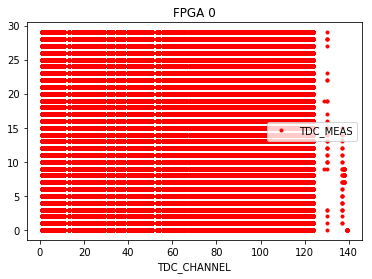

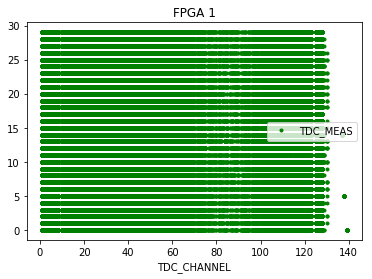

In [10]:
import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline 

dataplot1=pd.DataFrame(data[data['FPGA']==0])
mpl.rcParams['agg.path.chunksize'] = 1000
dataplot1.plot(x='TDC_CHANNEL',y='TDC_MEAS', title='FPGA 0',style='.', color='r')

dataplot2=pd.DataFrame(data[data['FPGA']==1])
mpl.rcParams['agg.path.chunksize'] = 1000
dataplot2.plot(x='TDC_CHANNEL',y='TDC_MEAS', title='FPGA 1',style='.', color='g')

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [24]:
maxcount=data.groupby(['TDC_CHANNEL'])['TDC_MEAS'].max()
maxcount.iloc[:3]

TDC_CHANNEL
1    29
2    29
3    29
Name: TDC_MEAS, dtype: int64

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [39]:
meas_channel_139=pd.DataFrame(data[data['TDC_CHANNEL']==139])
unique_meas_channel_139=meas_channel_139.drop_duplicates(subset=['ORBIT_CNT','BX_COUNTER'], inplace=False)
print("The number of unique orbits with at least one measurement from TDC_CHANNEL 139 is %d."%len(unique_meas_channel_139))

The number of unique orbits with at least one measurement from TDC_CHANNEL 139 is 107009.
